# COURSE: A deep understanding of deep learning
## SECTION: RNNs (and LSTM and GRU)
### LECTURE: Predicting alternating sequences
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202210

In [155]:
### import libraries
import torch
import torch.nn as nn
import numpy as np

# for printing out status reports
import sys

# for data visualization
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

C:\Users\lucan\AppData\Local\Temp\ipykernel_10600\3095297095.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


# Create temporal sequence data

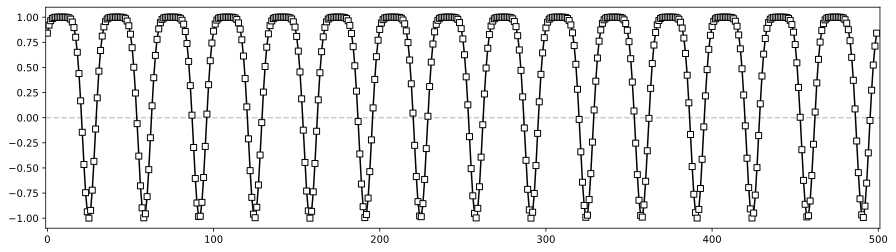

In [156]:
# import the data
N = 500
t = torch.linspace(0, 30*np.pi, N)
data = torch.sin(t + torch.cos(t))

plt.figure(figsize=(15,4))
plt.plot([-1,N+1],[0,0],'--',color=[.8,.8,.8])
plt.plot(data, 'ks-', markerfacecolor='w')
plt.xlim([-1,N+1])
plt.show()

# Create a class for the DL model

In [157]:
class rnnnet(nn.Module):
  def __init__(self,input_size,num_hidden,num_layers):
    super().__init__()

    # RNN Layer
    self.rnn = nn.RNN(input_size,num_hidden,num_layers)
    
    # linear layer for output
    self.out = nn.Linear(num_hidden,1)
  
  def forward(self, x):
    
    # run through the RNN layer
    y,hidden = self.rnn(x) # no explicit hidden state initialization
    
    # and the output (linear) layer
    y = self.out(y)
    
    return y,hidden

In [158]:
# network parameters
input_size =  1  # "channels" of data
num_hidden =  9  # breadth of model (number of units in hidden layers)
num_layers =  1  # depth of model (number of "stacks" of hidden layers)
seqlength  =  60 # number of datapoints used for learning in each segment
batchsize  =  1  # Note: the training code is actually hard-coded to organize data into batchsize=1

# create an instance of the model and inspect
net = rnnnet(input_size,num_hidden,num_layers)

X = torch.rand(seqlength,batchsize,input_size)
y,h = net(X)
print(X.shape)
print(y.shape) # note: one output per sequence element; generally, we take the final output to force a "many-to-one" design.
print(h.shape)

torch.Size([60, 1, 1])
torch.Size([60, 1, 1])
torch.Size([1, 1, 9])


In [159]:
# test the model with some data
somedata = data[:seqlength].view(seqlength,1,1)
y = net(somedata)

# grab the final predicted value from the output (first element of tuple output of net)
finalValue = y[0][-1]

lossfun = nn.MSELoss()
lossfun(finalValue,data[seqlength].view(1,1))

tensor(0.6844, grad_fn=<MseLossBackward0>)

# Train the model and show performance

In [160]:
# number of training epochs
numepochs = 30

# create a new instance of the model (and optimizer!)
net = rnnnet(input_size,num_hidden,num_layers)
optimizer = torch.optim.SGD(net.parameters(),lr=.001)



# initialize losses
losses = np.zeros(numepochs)
signaccuracy = np.zeros(numepochs)

# loop over epochs
for epochi in range(numepochs):

  # loop over data segments
  seglosses = []
  segacc    = []
  hidden_state = torch.zeros(num_layers,batchsize,num_hidden) # reset the hidden state on each epoch

  for timei in range(N-seqlength):

    # grab a snippet of data
    X = data[timei:timei+seqlength].view(seqlength,1,1)
    y = data[timei+seqlength].view(1,1)

    # forward pass and loss
    yHat,hidden_state = net(X)
    finalValue = yHat[-1]
    loss = lossfun(finalValue,y) # compare final value of output

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # loss from this segment
    seglosses.append(loss.item())

    diff = np.abs(torch.squeeze(y).item() - torch.squeeze(finalValue).detach().item())
    accuracy = 100 * (1 - diff)
    segacc.append(accuracy)
  
  # average losses from this epoch
  losses[epochi] = np.mean(seglosses)
  signaccuracy[epochi] = np.mean(segacc)
  
  msg = f'Finished epoch {epochi+1}/{numepochs}'
  sys.stdout.write('\r' + msg)

Finished epoch 30/30

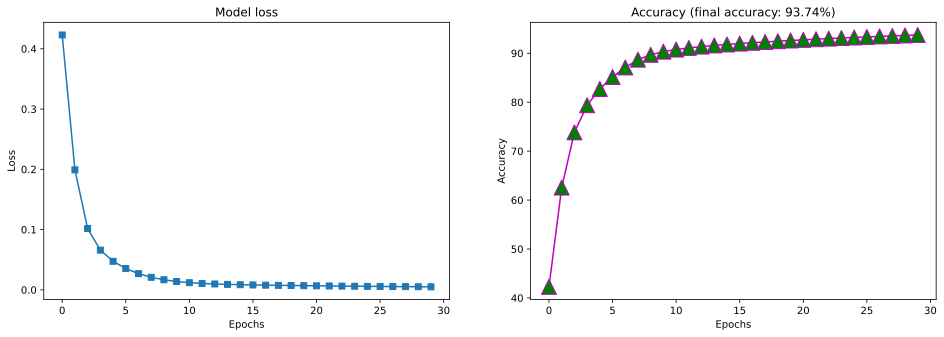

In [161]:
## let's see how the model did!

fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(signaccuracy,'m^-',markerfacecolor='g',markersize=15)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy (final accuracy: %.2f%%)'%signaccuracy[-1])

plt.show()

# Now test the network!


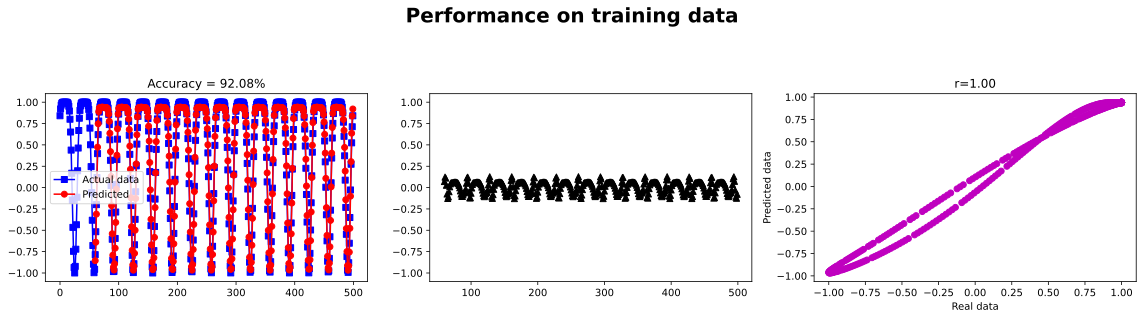

In [162]:
# initialize hidden state
h = np.zeros((N,num_hidden))

# initialize predicted values
yHat = np.zeros(N)
yHat[:] = np.nan


# loop over time segments
for timei in range(N-seqlength):

  # grab a snippet of data
  X = data[timei:timei+seqlength].view(seqlength,1,1)

  # forward pass and loss
  yy,hh = net(X)
  yHat[timei+seqlength] = yy[-1]
  h[timei+seqlength,:] = hh.detach()


## compute accuracy
signaccuracy = 100 * (1 - np.abs(data.numpy() - yHat))


## plot!
fig,ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(data,'bs-',label='Actual data')
ax[0].plot(yHat,'ro-',label='Predicted')
ax[0].set_ylim([-1.1,1.1])
ax[0].set_title('Accuracy = %.2f%%' %signaccuracy[-1])
ax[0].legend()

ax[1].plot(data-yHat,'k^')
ax[1].set_ylim([-1.1,1.1])

ax[2].plot(data[seqlength:],yHat[seqlength:],'mo')
ax[2].set_xlabel('Real data')
ax[2].set_ylabel('Predicted data')
r = np.corrcoef(data[seqlength:],yHat[seqlength:])
ax[2].set_title(f"r={r[0,1]:.2f}")

plt.suptitle('Performance on training data',fontweight='bold',fontsize=20,y=1.1)
plt.tight_layout()
plt.show()

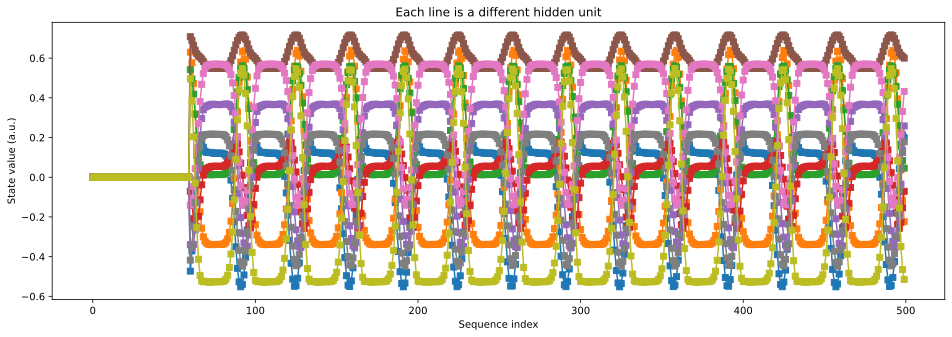

In [163]:
# show the hidden "states" (units activations)
plt.figure(figsize=(16,5))

plt.plot(h,'s-')
plt.xlabel('Sequence index')
plt.ylabel('State value (a.u.)')
plt.title('Each line is a different hidden unit')
plt.show()

# Test with new data

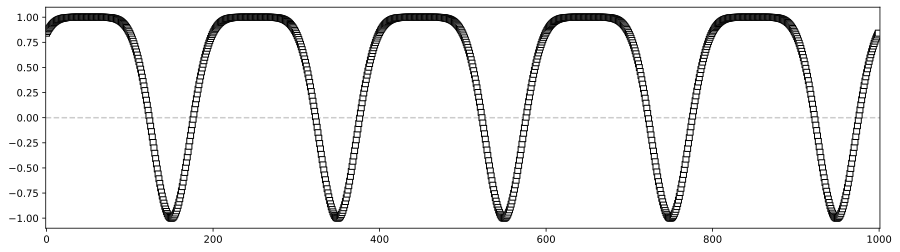

In [164]:
# Create new data
N = 1000
t = torch.linspace(0, 10*np.pi, N)
data = torch.sin(t + torch.cos(t))

plt.figure(figsize=(15,4))
plt.plot([-1,N+1],[0,0],'--',color=[.8,.8,.8])
plt.plot(data, 'ks-', markerfacecolor='w')
plt.xlim([-1,N+1])
plt.show()

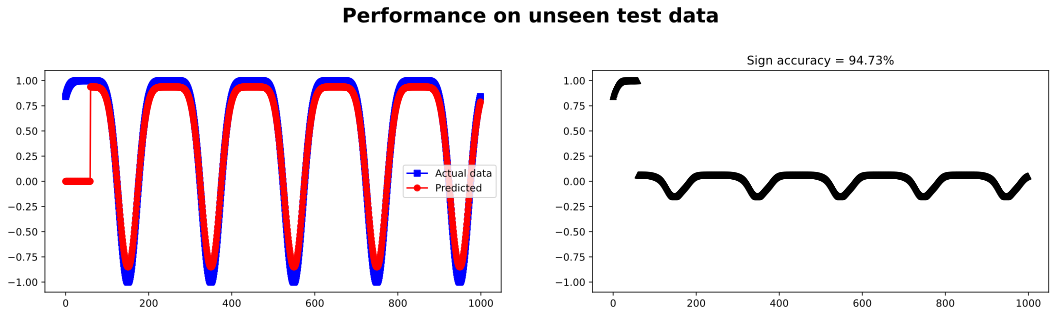

In [165]:
## now test the network!
# note: no learning here!

h = np.zeros((N,num_hidden))

yHat = np.zeros(N)
for timei in range(N-seqlength):

  # grab a snippet of data
  X = data[timei:timei+seqlength].view(seqlength,1,1)

  # forward pass and loss
  yy,hh = net(X)
  yHat[timei+seqlength] = yy[-1]
  h[timei+seqlength,:] = hh.detach()


# compute sign-accuracy
accuracy = 100 * (1 - np.abs(data.numpy() - yHat))


fig,ax = plt.subplots(1,2,figsize=(18,4))
ax[0].plot(data,'bs-',label='Actual data')
ax[0].plot(yHat,'ro-',label='Predicted')
ax[0].set_ylim([-1.1,1.1])
ax[0].legend()

ax[1].plot(data-yHat,'k^')
ax[1].set_ylim([-1.1,1.1])
ax[1].set_title('Sign accuracy = %.2f%%' %accuracy[-1])

plt.suptitle('Performance on unseen test data',fontweight='bold',fontsize=20,y=1.1)
plt.show()

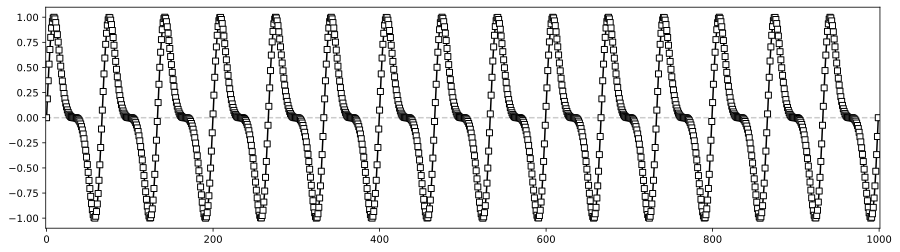

In [166]:
# Create new data
N = 1000
t = torch.linspace(0, 30*np.pi, N)
data = torch.sin(t + torch.sin(t))

plt.figure(figsize=(15,4))
plt.plot([-1,N+1],[0,0],'--',color=[.8,.8,.8])
plt.plot(data, 'ks-', markerfacecolor='w')
plt.xlim([-1,N+1])
plt.show()

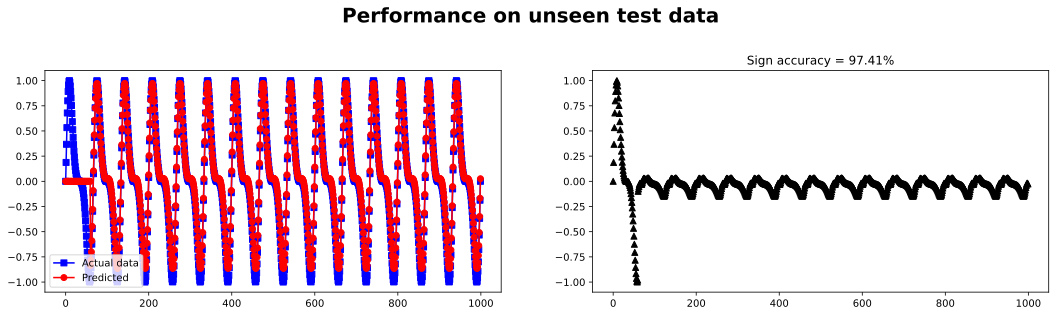

In [167]:
## now test the network!
# note: no learning here!

h = np.zeros((N,num_hidden))

yHat = np.zeros(N)
for timei in range(N-seqlength):

  # grab a snippet of data
  X = data[timei:timei+seqlength].view(seqlength,1,1)

  # forward pass and loss
  yy,hh = net(X)
  yHat[timei+seqlength] = yy[-1]
  h[timei+seqlength,:] = hh.detach()


# compute sign-accuracy
accuracy = 100 * (1 - np.abs(data.numpy() - yHat))


fig,ax = plt.subplots(1,2,figsize=(18,4))
ax[0].plot(data,'bs-',label='Actual data')
ax[0].plot(yHat,'ro-',label='Predicted')
ax[0].set_ylim([-1.1,1.1])
ax[0].legend()

ax[1].plot(data-yHat,'k^')
ax[1].set_ylim([-1.1,1.1])
ax[1].set_title('Sign accuracy = %.2f%%' %accuracy[-1])

plt.suptitle('Performance on unseen test data',fontweight='bold',fontsize=20,y=1.1)
plt.show()

# Part 2: Long-term extrapolation

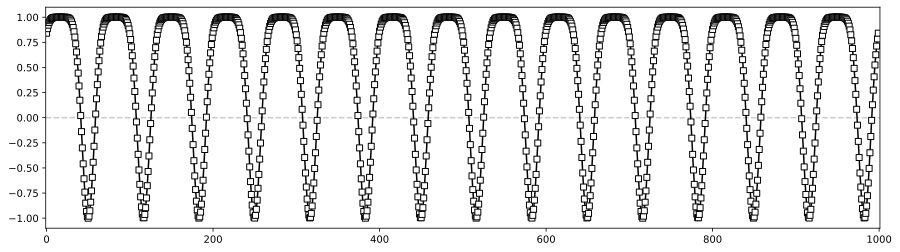

In [168]:
# Revert to original data
N = 1000
t = torch.linspace(0, 30*np.pi, N)
data = torch.sin(t + torch.cos(t))

plt.figure(figsize=(15,4))
plt.plot([-1,N+1],[0,0],'--',color=[.8,.8,.8])
plt.plot(data, 'ks-', markerfacecolor='w')
plt.xlim([-1,N+1])
plt.show()

timei 941 
 diff: 1 
 data_remainder len: 59 data: tensor([ 0.9975,  0.9988,  0.9995,  0.9998,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  0.9999,  0.9996,  0.9989,
         0.9977,  0.9953,  0.9913,  0.9849,  0.9750,  0.9605,  0.9399,  0.9118,
         0.8742,  0.8256,  0.7642,  0.6886,  0.5977,  0.4909,  0.3687,  0.2320,
         0.0833, -0.0742, -0.2360, -0.3966, -0.5501, -0.6900, -0.8099, -0.9041,
        -0.9678, -0.9978, -0.9925, -0.9521, -0.8788, -0.7764, -0.6498, -0.5052,
        -0.3489, -0.1873, -0.0263,  0.1290,  0.2744,  0.4069,  0.5246,  0.6266,
         0.7129,  0.7841,  0.8415]) 
 data_pred len: 1 data: tensor([0.8432], grad_fn=<SliceBackward0>)
remaining data: 59 + predicted data: 1
timei 942 
 diff: 2 
 data_remainder len: 58 data: tensor([ 0.9988,  0.9995,  0.9998,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  0.9999,  0.9996,  0.9989,  0.9977,
         0.9953,  0.9913,  0.9849, 

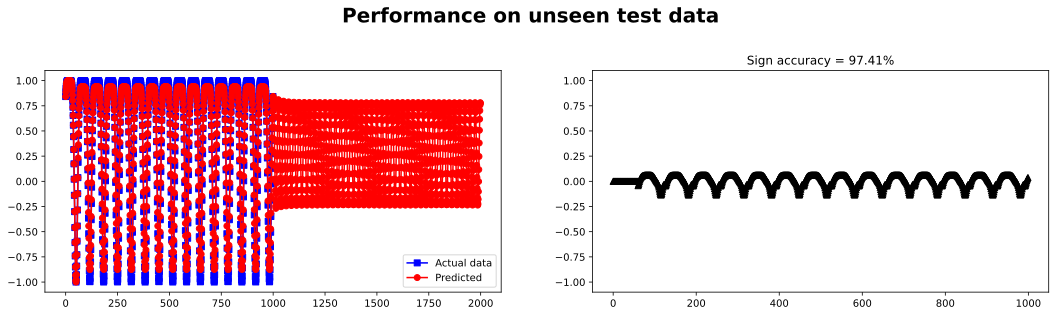

In [170]:
## now try to generate new data

# First predict existing values
yHat = torch.zeros(2*N)
yHat[:N] = data
for timei in range(2*N-seqlength):

  # X = yHat[timei:timei+seqlength].view(seqlength,1,1)

  # grab a snippet of data
  if timei <= N - seqlength:
    X = data[timei:timei+seqlength].view(seqlength,1,1)

  # transition from data to predicted values
  elif N - seqlength < timei < N:
    diff = timei + seqlength - N
    data_remainder = data[timei:]   # Rest of data: [timei, N)
    data_pred = yHat[N: N + diff]   # Supplement data with predicted values: [N, N + diff)

    print(f"timei {timei} \n diff: {diff} \n data_remainder len: {len(data_remainder)} data: {data_remainder} \n data_pred len: {len(data_pred)} data: {data_pred}")
    print(f"remaining data: {len(data_remainder)} + predicted data: {len(data_pred)}")

    X = torch.concat((data_remainder, data_pred)).view(seqlength,1,1)
  # only use predicted values
  elif timei >= len(data):
    X = yHat[timei:timei+seqlength].view(seqlength,1,1)
  else:
    print("ERROR: Could not select values!")
    break

  # forward pass and loss
  yy, _ = net(X)
  yHat[timei+seqlength] = yy[-1]

yHat = yHat.detach().numpy()

# compute sign-accuracy
# accuracy = 100 * (1 - np.abs(data.numpy() - yHat))


fig,ax = plt.subplots(1,2,figsize=(18,4))
ax[0].plot(data,'bs-',label='Actual data')
ax[0].plot(yHat,'ro-',label='Predicted')
ax[0].set_ylim([-1.1,1.1])
ax[0].legend()

ax[0].set_xlim(900, 1100)

ax[1].plot(data-yHat[:N],'k^')
ax[1].set_ylim([-1.1,1.1])
ax[1].set_title('Sign accuracy = %.2f%%' %accuracy[-1])

plt.suptitle('Performance on unseen test data',fontweight='bold',fontsize=20,y=1.1)
plt.show()